In [1]:
import re
import ast
import pickle
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from functional import seq
from loguru import logger

from matplotlib.font_manager import FontProperties
from matplotlib import rcParams

config = {
            "font.family": "serif",
            "font.size": 12,
            "mathtext.fontset": "stix",# matplotlib渲染数学字体时使用的字体，和Times New Roman差别不大
            "font.serif": ["STZhongsong"],# 华文中宋
            "axes.unicode_minus": False # 处理负号，即-号
         }
rcParams.update(config)


In [2]:
df = pd.read_csv("./results/extract_df.csv", header=0)
df.head(1)

,staff_id,NIPTS,Leq,LAeq,LCeq,kurtosis_geomean,A_kurtosis_geomean,C_kurtosis_geomean
0,Gengde electronic equipment factory-0,9.0,99.808967,97.332718,96.446445,5.272739,5.849593,5.652735


In [3]:
df.index = df["staff_id"]
df.drop("staff_id", axis=1, inplace=True)
df.head(1)

,NIPTS,Leq,LAeq,LCeq,kurtosis_geomean,A_kurtosis_geomean,C_kurtosis_geomean
staff_id,,,,,,,
Gengde electronic equipment factory-0,9.0,99.808967,97.332718,96.446445,5.272739,5.849593,5.652735


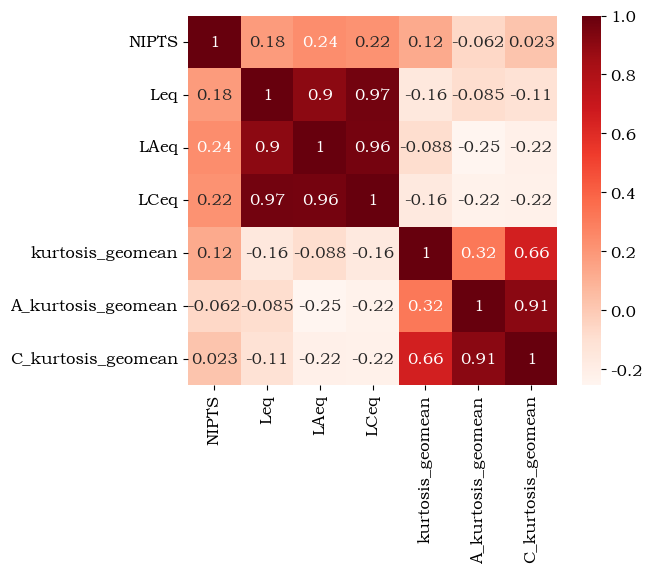

In [4]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix,annot = True,vmax = 1,square = True,cmap = "Reds")
plt.show()

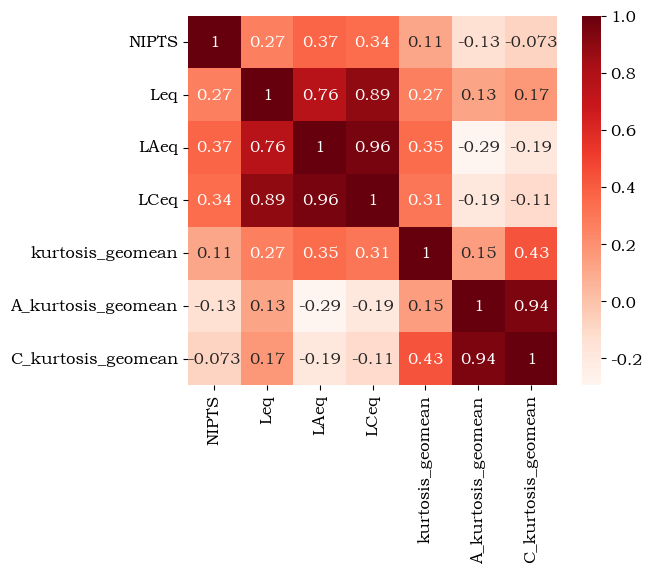

In [5]:
high_kurtosis_df = df[df["kurtosis_geomean"]>=df["kurtosis_geomean"].quantile(3/4)]
corr_matrix = high_kurtosis_df.corr()
sns.heatmap(corr_matrix,annot = True,vmax = 1,square = True,cmap = "Reds")
plt.show()

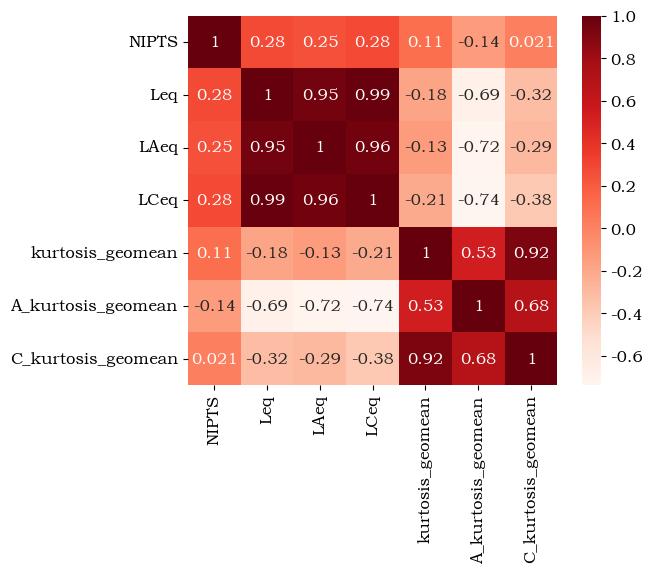

In [6]:
low_kurtosis_df = df[df["kurtosis_geomean"]<=df["kurtosis_geomean"].quantile(1/4)]
corr_matrix = low_kurtosis_df.corr()
sns.heatmap(corr_matrix,annot = True,vmax = 1,square = True,cmap = "Reds")
plt.show()

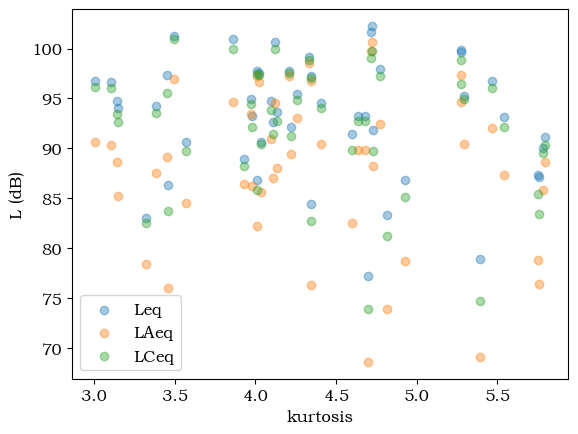

In [7]:
plot_df = low_kurtosis_df
plt.scatter(plot_df["kurtosis_geomean"], plot_df["Leq"], label="Leq", alpha=0.4)
plt.scatter(plot_df["kurtosis_geomean"], plot_df["LAeq"], label="LAeq", alpha=0.4)
plt.scatter(plot_df["kurtosis_geomean"], plot_df["LCeq"], label="LCeq", alpha=0.4)
plt.legend(loc="best")
plt.xlabel("kurtosis")
plt.ylabel("L (dB)")
plt.show()

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR


X = df.drop("NIPTS", axis=1)
y = df.NIPTS

train_x, test_x, train_y, test_y = train_test_split(X,y,test_size=0.3,random_state=42)

svm_model = SVR()

logger.info(SVR().get_params())

params = [
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
    {"kernel": ["poly"], "C": [1], "degree":[2, 3]},
    {"kernel": ["rbf"], "C": [1, 10, 100, 1000], "gamma": [1, 0.1, 0.01, 0.001]}
]

best_model = GridSearchCV(svm_model, param_grid=params, cv=5, scoring="neg_mean_absolute_error")
best_model.fit(train_x, train_y)

logger.info(best_model.best_params_)
logger.info(best_model.best_estimator_)
logger.info(best_model.cv_results_)

2024-01-04 16:30:23.628 | INFO     | __main__:<module>:13 - {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
2024-01-04 16:32:04.090 | INFO     | __main__:<module>:24 - {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
2024-01-04 16:32:04.091 | INFO     | __main__:<module>:25 - SVR(C=1, gamma=0.001)
2024-01-04 16:32:04.109 | INFO     | __main__:<module>:26 - {'mean_fit_time': array([5.43445110e-02, 1.11527596e+00, 3.53897591e+00, 1.53397326e+01,
       6.08778000e-04, 2.50144005e-03, 0.00000000e+00, 2.00128555e-04,
       5.25617599e-04, 2.08582878e-03, 2.48956680e-03, 9.97447968e-04,
       1.32446289e-03, 2.40850449e-04, 1.59482956e-03, 1.59468651e-03,
       1.70421600e-03, 1.01890564e-03, 1.50051117e-03, 2.90951729e-03,
       2.59618759e-03, 2.79040337e-03]), 'std_fit_time': array([3.09655382e-02, 1.43479629e+00, 2.90827663e+00, 1.24291200e+01,
       4.97452686e-0

In [9]:
y_predict = best_model.predict(test_x)
rmse = mean_absolute_error(test_y, y_predict)
logger.info(f"RMSE={rmse}")

2024-01-04 16:32:04.113 | INFO     | __main__:<module>:3 - RMSE=8.44328027410443


2024-01-04 16:36:50.141 | INFO     | __main__:<module>:13 - RMSE=9.845310734463276


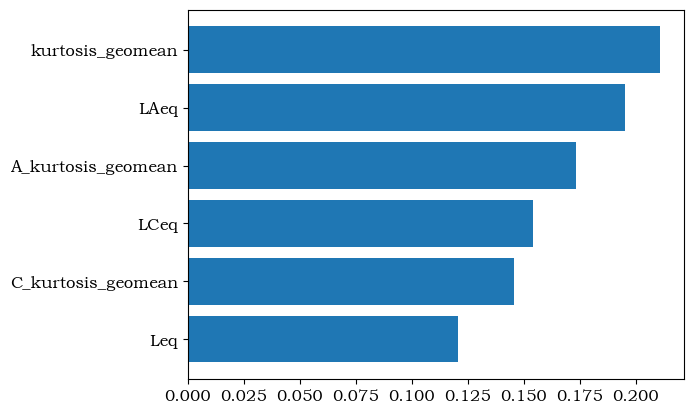

In [19]:
from sklearn.ensemble import RandomForestRegressor

X = df.drop("NIPTS", axis=1)
y = df.NIPTS

train_x, test_x, train_y, test_y = train_test_split(X,y,test_size=0.3,random_state=42)

tree_model = RandomForestRegressor()
tree_model.fit(train_x, train_y)

y_predict = tree_model.predict(test_x)
rmse = mean_absolute_error(test_y, y_predict)
logger.info(f"RMSE={rmse}")

importances = tree_model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(train_x.columns)[indices])

2024-01-04 16:32:04.902 | INFO     | __main__:<module>:13 - RMSE=14.123333333333333


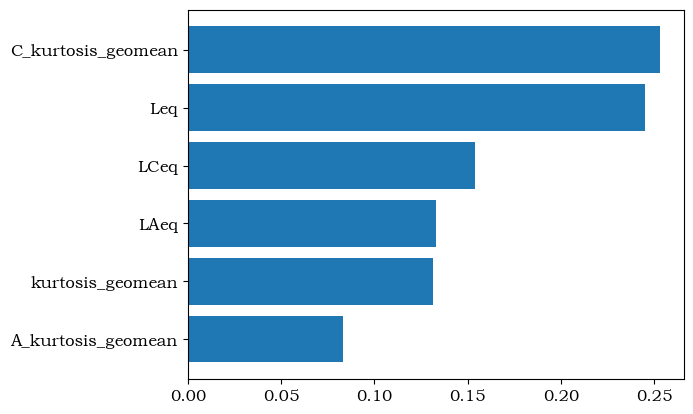

In [10]:
X = high_kurtosis_df.drop("NIPTS", axis=1)
y = high_kurtosis_df.NIPTS

train_x, test_x, train_y, test_y = train_test_split(X,y,test_size=0.3,random_state=42)

tree_model = RandomForestRegressor()
tree_model.fit(train_x, train_y)

y_predict = tree_model.predict(test_x)
rmse = mean_absolute_error(test_y, y_predict)
logger.info(f"RMSE={rmse}")

importances = tree_model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(train_x.columns)[indices])

2024-01-04 16:32:05.046 | INFO     | __main__:<module>:11 - RMSE=8.22022222222222


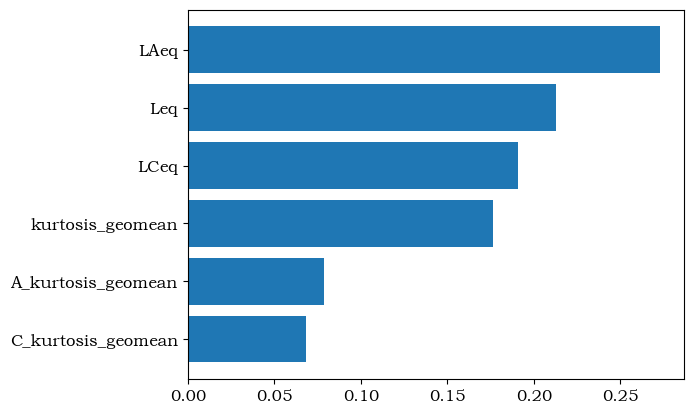

In [11]:
X = low_kurtosis_df.drop("NIPTS", axis=1)
y = low_kurtosis_df.NIPTS

train_x, test_x, train_y, test_y = train_test_split(X,y,test_size=0.3,random_state=42)

tree_model = RandomForestRegressor()
tree_model.fit(train_x, train_y)

y_predict = tree_model.predict(test_x)
rmse = mean_absolute_error(test_y, y_predict)
logger.info(f"RMSE={rmse}")

importances = tree_model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(train_x.columns)[indices])

In [12]:
logger.info(f"{high_kurtosis_df.shape}")
logger.info(f"{low_kurtosis_df.shape}")


2024-01-04 16:32:05.114 | INFO     | __main__:<module>:1 - (49, 7)
2024-01-04 16:32:05.114 | INFO     | __main__:<module>:2 - (49, 7)


In [14]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
poly_train_x = poly.fit_transform(train_x)

In [51]:
def RF_poly(df, poly=1):
    X = df.drop("NIPTS", axis=1)
    y = df.NIPTS

    poly = PolynomialFeatures(degree=poly, include_bias=False)
    X = poly.fit_transform(X)

    train_x, test_x, train_y, test_y = train_test_split(X,y,test_size=0.3,random_state=42)

    tree_model = RandomForestRegressor()
    tree_model.fit(train_x, train_y)

    y_predict = tree_model.predict(test_x)
    rmse = mean_absolute_error(test_y, y_predict)
    logger.info(f"RMSE={rmse}")

    importances = tree_model.feature_importances_
    indices = np.argsort(importances)

    fig, ax = plt.subplots()
    ax.barh(range(len(importances)), importances[indices])
    ax.set_yticks(range(len(importances)))
    _ = ax.set_yticklabels(np.array(poly.get_feature_names_out())[indices])
    logger.info("\n".join(np.array(poly.get_feature_names_out())[indices]))
    
    plt.show()

2024-01-04 17:18:42.651 | INFO     | __main__:RF_poly:15 - RMSE=9.696666666666665
2024-01-04 17:18:42.813 | INFO     | __main__:RF_poly:24 - LAeq+LCeq LCeq/A_kurtosis
LAeq+LCeq LCeq/C_kurtosis
LAeq/C_kurtosis LCeq/C_kurtosis
LAeq+LCeq LCeq/kurtosis
LCeq+C_kurtosis LAeq/C_kurtosis
LAeq/A_kurtosis LCeq/A_kurtosis
LAeq LAeq/C_kurtosis
LAeq+kurtosis LCeq/C_kurtosis
LAeq/C_kurtosis
Leq LCeq/A_kurtosis
kurtosis_geomean LAeq+A_kurtosis
C_kurtosis_geomean LCeq+kurtosis
LAeq+C_kurtosis LCeq/C_kurtosis
C_kurtosis_geomean LCeq+A_kurtosis
LAeq/kurtosis LAeq/C_kurtosis
A_kurtosis_geomean LCeq+C_kurtosis
LCeq+A_kurtosis LCeq/A_kurtosis
LCeq/kurtosis LCeq/A_kurtosis
C_kurtosis_geomean LAeq+C_kurtosis
LCeq+kurtosis LCeq/kurtosis
LCeq+C_kurtosis LCeq/C_kurtosis
Leq LCeq/C_kurtosis
LAeq/kurtosis LCeq/kurtosis
LCeq LAeq/C_kurtosis
LAeq/A_kurtosis LCeq/kurtosis
LAeq LAeq/A_kurtosis
A_kurtosis_geomean LAeq+LCeq
LCeq/A_kurtosis
LAeq LCeq
LAeq LCeq/C_kurtosis
LAeq+LCeq LAeq/A_kurtosis
LCeq A_kurtosis_geomean

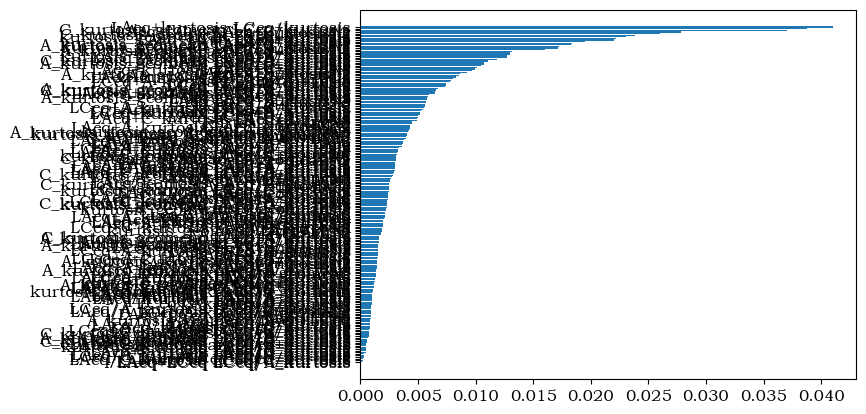

In [54]:
RF_poly(df,2)

2024-01-04 16:55:07.049 | INFO     | __main__:RF_poly:15 - RMSE=14.144888888888886


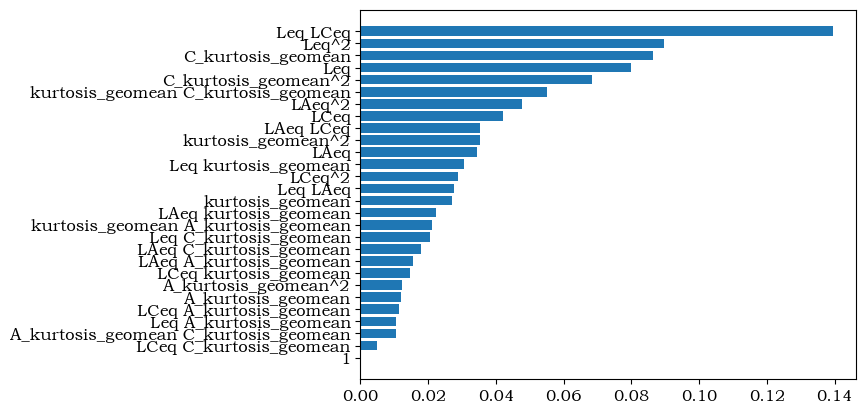

In [31]:
RF_poly(df=high_kurtosis_df)

2024-01-04 16:55:10.253 | INFO     | __main__:RF_poly:15 - RMSE=7.874222222222223


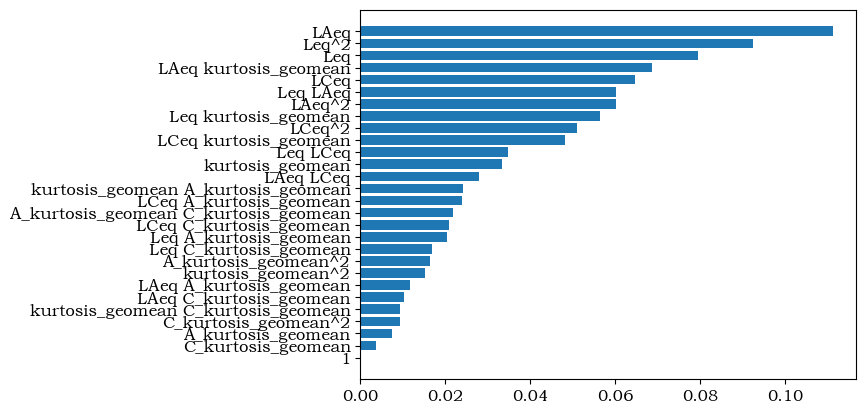

In [32]:
RF_poly(df=low_kurtosis_df)

In [47]:
df["LAeq+LCeq"] = df["LAeq"] + df["LCeq"]
df["LAeq+kurtosis"] = df["LAeq"] + df["kurtosis_geomean"]
df["LAeq+A_kurtosis"] = df["LAeq"] + df["A_kurtosis_geomean"]
df["LAeq+C_kurtosis"] = df["LAeq"] + df["C_kurtosis_geomean"]
df["LCeq+kurtosis"] = df["LCeq"] + df["kurtosis_geomean"]
df["LCeq+A_kurtosis"] = df["LCeq"] + df["A_kurtosis_geomean"]
df["LCeq+C_kurtosis"] = df["LCeq"] + df["C_kurtosis_geomean"]
df["LAeq/kurtosis"] = df["LAeq"] / df["kurtosis_geomean"]
df["LAeq/A_kurtosis"] = df["LAeq"] / df["A_kurtosis_geomean"]
df["LAeq/C_kurtosis"] = df["LAeq"] / df["C_kurtosis_geomean"]
df["LCeq/kurtosis"] = df["LCeq"] / df["kurtosis_geomean"]
df["LCeq/A_kurtosis"] = df["LCeq"] / df["A_kurtosis_geomean"]
df["LCeq/C_kurtosis"] = df["LCeq"] / df["C_kurtosis_geomean"]

2024-01-04 17:15:41.064 | INFO     | __main__:RF_poly:15 - RMSE=9.73632768361582


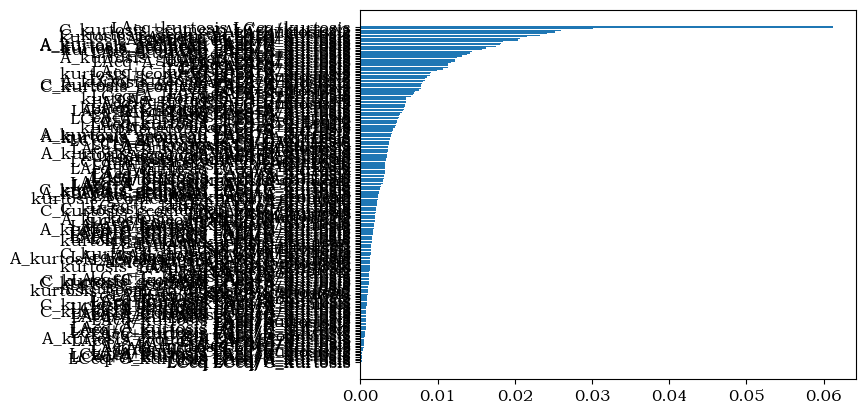

In [50]:
RF_poly(df=df, poly=2)